# Table of Contents
1. Introduction
2. Load Data & Libraries
3. Exploratory Analysis
4. Discussion
5. Conclusion
6. About the Author
7. Bonus Function


## 1. Introduction

The purpose of this project is to conduct an exploratory analysis of the Dow Jones Industrial Average (DJIA) and analyze results. The dataset used is a 5-year time series containing monthly values for the Dow Jones Industrial Average and the equity value for the 30 securities that comprise the Dow Jones index. It is a 60-row x 30-column dataset obtained from Yahoo Finance. In particular, we will be implementing multiple models to see which "best fits."

In this exploratory analysis, I implement a linear model, an autoregressive model, a moving average model and a transformation of the data. I discuss results in the discussion section and announce future plans for analysis in the conclusion. I end this study with a fun function at the end. Thanks for reading!

## 2. Load Data & Libraries

In [796]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

DJ_Data = pd.read_csv("DJ Data.csv")
headers = DJ_Data.columns.values
data = DJ_Data.iloc[:,2:]
returns = data.pct_change()*100
returns = returns[1:]

## 3. Exploratory Analysis

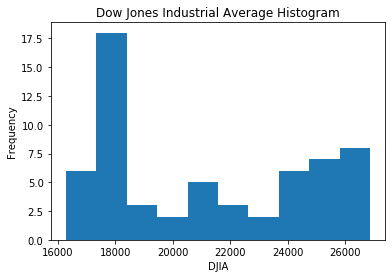

In [797]:
DJ_prices = DJ_Data['Dow']
DJ_Data['Month'] = np.arange(0,60)
months = DJ_Data['Month']
plt.hist(DJ_prices)
plt.title('Dow Jones Industrial Average Histogram')
plt.xlabel('DJIA')
plt.ylabel('Frequency')
plt.show()

This visualization is a histogram of the Dow Jones Industrial Average (DJIA) values. It shows the frequency of the DJIA values over the past 5 years. There are obvious confounders that discredit much of the usage of this visualization, but it is still interesting to see that the DJIA value tends to trend as one extreme or another rather than form a sort of normal distribution.

#### 3.1 Simple Linear Regression Model

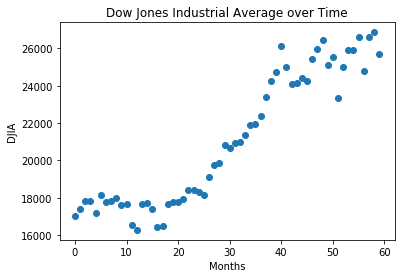

In [798]:
plt.scatter(months,DJ_prices)
plt.title('Dow Jones Industrial Average over Time')
plt.xlabel('Months')
plt.ylabel('DJIA')
plt.show()

Immediately we see that the DJIA scatter plot is generally increasing although perhaps not in the most linear fassion There appears to be an almost exponential rise that then flattens out. We might also be concerned about heteroskedasticity - varying variance as you progress along the data - but because the dataset is small (n = 60) we will proceed assuming the homoskedastic assumption of a linear model is met.

In [799]:
lm = linear_model.LinearRegression()
DJ_prices = DJ_Data['Dow'].values.reshape(-1,1)
months = DJ_Data['Month'].values.reshape(-1,1)
lmfit = lm.fit(months, DJ_prices)
print("The linear regression formula is: DJ value = {} + {}*months".format(lmfit.intercept_[0],lmfit.coef_[0][0]))

The linear regression formula is: DJ value = 15467.664879387976 + 191.43887867046408*months


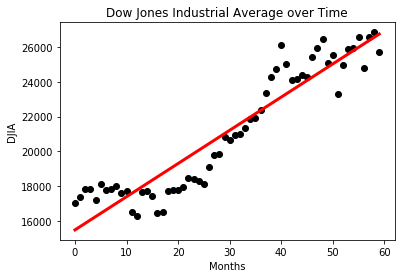

In [800]:
full_pred = lmfit.predict(months)
plt.scatter(months,DJ_prices,color='black')
plt.plot(months,full_pred,color='red',linewidth=3)
plt.title('Dow Jones Industrial Average over Time')
plt.xlabel('Months')
plt.ylabel('DJIA')
plt.show()

*Note: the red line is the linear regression line following the ordinary least square methodology. The black dots are the raw data.*

Since this is a monthly study spanning 5 years (n = 60 data points), there is not enough data to warrant the implementation of multiple linear models. As such, we will proceed with one simple linear regression model and evaluate slightly more complex models.

Let's also evaluate the potential for autocorrelation - the notion that a point of data in the set is correlated with the previous n points of data..

#### 3.2 Working with Autocorrelation

Let's evaluate whether or not autocorrelation exists in the dataset consisting of DJIA values. For simplicity, I used the partial autocorrelation function to evaluate the corresponding appropriate lag to attribute to the model, but one could also evaluate this step by analyzing the durbin watson test statistic (to test for lag = 1), analyzing a standardized residuals vs time plot or conducting a 'runs' test based on the sequence plot.

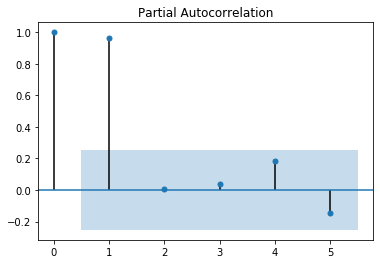

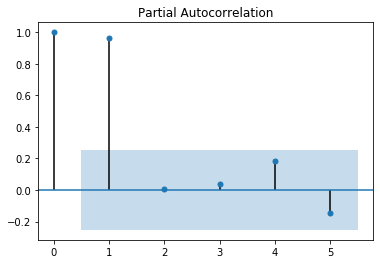

In [801]:
plot_pacf(DJ_prices, lags = 5)

From this partial autocorrelation function, we see that there mainly appears to be autocorrelation at the lag-1 and lag-2 levels but not beyond. Therefore, the linear model looks like y_t = β_0 + β_1 * y_(t−1) + β_2 * y_(t−2) + ϵ_t before a cochrane-orcutt transformation

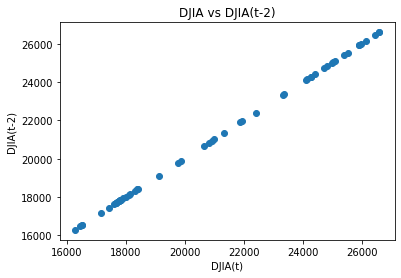

In [802]:
# scatter plot of y(t) vs y(t-2)
DJ_Data['lag-0 DJ'] = DJ_Data['Dow'].iloc[2:]
DJ_Data['lag-1 DJ'] = DJ_Data['Dow'].iloc[1:59]
DJ_Data['lag-2 DJ'] = DJ_Data['Dow'].iloc[:58]
plt.scatter(DJ_Data['lag-0 DJ'], DJ_Data['lag-2 DJ'])
plt.title('DJIA vs DJIA(t-2)')
plt.ylabel('DJIA(t-2)')
plt.xlabel('DJIA(t)')
plt.show()

The lag-2 plot demonstrates a highly linear relationship, suggesting second-order autoregression. This means that each DJIA is dependent on its prior two values.

##### 3.2.1 Second-Order Autocorrelation Model

In [766]:
X_train, X_test = DJ_Data[['lag-1 DJ','lag-2 DJ']].iloc[2:-10,:], DJ_Data[['lag-1 DJ','lag-2 DJ']].iloc[-10:-2,:]
y_train, y_test = DJ_Data[['lag-0 DJ']].iloc[2:-10,:], DJ_Data[['lag-0 DJ']].iloc[-10:-2,:]
lmfit_L2 = lm.fit(X_train, y_train)
print("The linear regression formula is: DJ value = {} + {}*lag-1_DJ + {}*lag-2_DJ".format(
    lmfit_L2.intercept_[0],
    lmfit_L2.coef_[0][0],
    lmfit_L2.coef_[0][1]))

The linear regression formula is: DJ value = 7.275957614183426e-12 + 0.49999999999999983*lag-1_DJ + 0.49999999999999983*lag-2_DJ


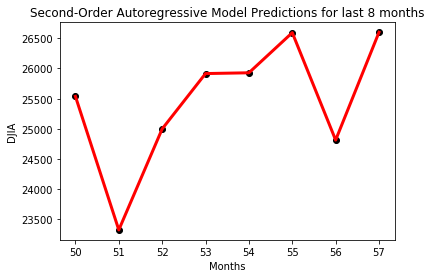

In [769]:
months_L2_test = months[-10:-2]
predictions_L2 = lmfit_L2.predict(X_test)
plt.scatter(months_L2_test,DJ_prices[-10:-2],color='black')
plt.plot(months_L2_test,predictions_L2,color='red',linewidth=3)
plt.title('Second-Order Autoregressive Model Predictions for last 8 months')
plt.xlabel('Months')
plt.ylabel('DJIA')
plt.show()

##### 3.2.2 Calculating Mean-Square Error (MSE)

In [776]:
def mse(arr_1,arr_2):
    return np.sum((arr_1-arr_2)**2)
mse_L2 = mse(predictions_L2.reshape(1,-1)[0],DJ_prices[-10:-2])
mse_L2

0.0

Both the plot of a second-order autoregression model and the calculated mean-squared error suggest an extreme overfitting of the data. A smoother fitting model would better represent our understanding of overall trends. As such, we will proceed with a moving average (MA) model in an effort to better understand overall movement in the data. 

#### 3.3 Moving Average Model

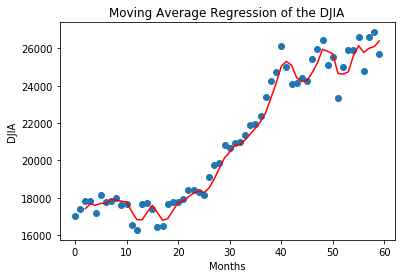

In [780]:
# We will focus on using a trailing moving average
rolling = DJ_Data['Dow'].rolling(window = 3)
roll_mean = rolling.mean()
plt.scatter(DJ_Data['Month'],DJ_Data['Dow'])
plt.plot(roll_mean, color = 'red')
plt.xlabel('Months')
plt.ylabel('DJIA')
plt.title('Moving Average Regression of the DJIA')
plt.show()

*Note: The red line is the moving average regression. The blue dots are the DJIA data.*
the MA model with lag=2 appears to be fitting the data trends much better compared to the autocorrelation model which overfit the data. 

##### 3.3.1 MSE and Other Computations

In [778]:
mse_MA = mse(roll_mean[2:],DJ_Data['Dow'][2:])
mse_MA

18161718.583800048

While the MSE is much bigger, we see from the plot that the MA regression appears to be tracking overall trends much more and might even be underfitting the data a bit. Let's track if this is true or not.

In [469]:
def fit_count(arr_1,arr_2):
    return [np.sum(arr_1-arr_2 > 0, axis=0),np.sum(arr_1-arr_2 < 0,axis = 0)]
pos_MA,neg_MA = fit_count(roll_mean[2:],DJ_Data['Dow'][2:])
print('the moving average model overfit the data {} times and underfit the data {} times'.format(pos_MA,neg_MA))

the moving average model overfit the data 20 times and underfit the data 38 times


We see that the moving average model does appear to have underfit the data significantly more often than it overfit the data. Let's continue this process by accounting for some amount of error by incorporating standard deviation into the model.

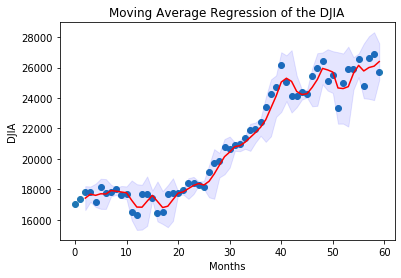

In [781]:
path_deviation = 2 * DJ_Data['Dow'].rolling(window = 3).std()
plt.scatter(DJ_Data['Month'],DJ_Data['Dow'])
plt.plot(roll_mean, color = 'red')
plt.fill_between(path_deviation.index, (roll_mean-path_deviation), (roll_mean+path_deviation), color='b', alpha=.1)
plt.xlabel('Months')
plt.ylabel('DJIA')
plt.title('Moving Average Regression of the DJIA')
plt.show()

All the data appears to visually fit within one standard deviation of the red line. Let's make sure this is true...

In [478]:
def fit_count_std(arr,regr_arr,std_arr):
    high = regr_arr+std_arr
    low = regr_arr-std_arr
    return np.count_nonzero((arr > high) & (arr < low))
count = fit_count_std(DJ_Data['Dow'][2:],roll_mean[2:],path_deviation[2:])
count

0

We see that all of the data falls within one standard deviation of the moving average model. For the sake of experimentation, let's see how a logarithmic transformation of the data might affect our results.

#### 3.4 Implementing a Transformation

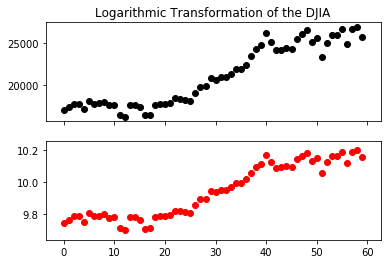

In [807]:
DJ_Data['Log Dow'] = np.log(DJ_Data['Dow'])
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(DJ_Data['Month'],DJ_Data['Dow'], color = 'black')
axarr[0].set_title('Logarithmic Transformation of the DJIA')
axarr[1].scatter(DJ_Data['Month'], DJ_Data['Log Dow'],color = 'red')
plt.show()

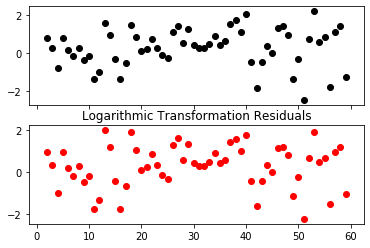

In [813]:
rolling_log = DJ_Data['Log Dow'].rolling(window = 3)
roll_mean_log = rolling_log.mean()

def standardize(arr):
    return arr/np.std(arr, axis = 0)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(DJ_Data['Month'], standardize(DJ_Data['Dow'][2:]-roll_mean),color = 'black')
axarr[1].set_title('Logarithmic Transformation Residuals')
axarr[1].scatter(DJ_Data['Month'],standardize(DJ_Data['Log Dow'][2:]-roll_mean_log), color = 'red')
plt.show()

We see that the logarithmic transformation did not help us with the interpretability of the data. Logarithmic transformations simply affect the skew of the data's distribution. To fix heteroskedasticity we need to implement either a weighted least square regression or variance-stabilizing regression.

## 4. Discussion

In this Study, we have tested the results of implementing a linear regression model, a second-order autoregression model, a moving average model and a logarithmic transformation. Now we will discuss individually their pros and cons. In the next section, we will conclude this study with some final comments and future plans. The final section is an "About the Author." I end this study with a fun little bonus function. Let's begin the Discussion.

#### 4.1 Linear Regression Model

A linear model has the following assumptions:
Assumptions about the errors-
1. normality of the errors
2. Homoskedasticity
3. mean of the errors = 0
Assumptions about the predictors-
1. predictor variables are selected in advance and are fixed
2. predictor variables are linearly independent (no coliniearity/multicolinearity
Assumptions about the observations
1. all observations are equally reliable and have an equal role in predicting the regressed variable

*From "Regression Analysis by Example, Fifth Edition written by Samprit Chatterjee and Ali S. Hadi"*

Our model appears to violate homoskedasticity yet I proceed with the model as is due to a lack of data. I assume that homoskedasticity would be roughly met if provided further data.

In future parts of this project, I also intend to test a weighted least square regression in which certain data points will provide more weight than others in predicting the regressed variable. In doing so, I would obtain a more homoskedastic model that also explains more of the variance in the data.

In addressing autocorrelation, I intend to implement a cochrane-orcutt transformation in the next part of this model as well and further analyze those results. 

While usage of a simple linear regression model might not be the most accurate, It allows us to begin to deconstruct aspects of the data and further understand patterns in the Dow Jones Industrial Average over time. Furthermore, via implementation of a simple linear regression model, we can beginto see where future endeavors must lead in order to create a model that better tracks the data's trends. Implementation of wls and cochrane-orcutt or another variance-stabilizing model will enable us to better visualize trends in the data.

#### 4.2 Second-Order Autoregression Model

We've shown that the DJIA exhibits a lag of 2. This led us to the development of a second-order autocorrelation model. The result was an extreme overfitting of the data. It is often the case that overfit models perform worse in tracking new data than models which are not overfit. In a future analysis, we will conduct a cochrane-orcutt transformation and estimate ρ using OLS and setting εi = ρ_1 * ε_i-2 + ρ_2 * ε_i-1 + δi. Then we can substitute ρ in the generalized linear regression formula. 

#### 4.3 Moving Average Model

As a result of overfitting of the autoregression model, we tested a moving average model to see if we could get a smoother plot. Indeed, we did. The moving average plot performed the best in tracking general trends in the DJIA data. Both autoregressive and moving average models are useful for testing univariate time-series data without seasonality. Future plans include testing an autoregressive moving average (ARMA) model which incorporates components of the two individual models. Then, to incporporate trend, utilize an autoregressive integrative moving average (ARIMA) model, the next step in the process. This model will better account for trend in the data. 

#### 4.4 Log Transformation

Log transformations make highly skewed data less skewed so one can better understand the data. Since our data had practically no skew to begin with, the log transformation did not help us transform the data so it could be more easily interpreted. This is an example in which the transformation we require is a variance-stabilizing transformation or weighted least-square regression to fix potential heteroskedasticity and make the data more interpretable. 

## 5. Conclusion

Further analysis require implementation of a weighted least squares regression or variance stabilizing regression. Skit-learn does not have a function for weigthed least-square but there is an parameter for sample_weights in the fit() function within linear regression. Further analysis will also require implementation of an ARMA and ARIMA model to combine components of the autoregression and moving average model we have implemented in this exploratory analysis. 

Thank you for taking the time to view this project. It was an excellent opportunity for me to find my own dataset (I utilized Yahoo Finance), and begin to combine my statistics foundation with my coding experience to conduct an exploratory analysis on a real-world data set. This project also served as a learning opportunity to begin implementing predictive analytics on the Dow Jones Industrial Average. I intend to conduct future analyses on the DJIA and its 30 securities. While I may have an easier experience conducting these analysis in R due to it's statistical coding ease, I intend to continue utilizing python to better familiarize myself with its coding libraries including skit-learn, statsmodels, pandas and eventually SciPy. 

## 6. About the Author

Currently, I am a senior at the University of Chicago and am pursing a B.A. in Statistics. I have proficiency in Python, R, MATLAB, SQL, Java, and C programming languages. Most recently, I interned with PPM America, a global investment management firm. I collaborated with senior executives in the Quantitative Research and Risk Management department to conduct and present computational analyses to the Chief Investment Officer and several investment professionals. This internship was an incredible opportunity to learn from the quantitative research analysts and contribute back to the firm via engagement on various projects by implementing my statistics background. Last summer, I interned with Indus Capital Partners and utilized Bloomberg Mnemonics (BQL, BDP, BDH) to construct an equity report model for firm-wide usage. I also had the opportunity to shadow the Head of Risk and Finance Data Integrity at Credit Suisse. I learned about how Investment Banks are utilizing Big Data, leveraging alternative data sources, and presented one-such way competing banks were doing so to executives at Credit Suisse. In Summer 2017, I interned for Huxley Banking and Financial Services and supported their technology recruiting teams via market research. 

At the University of Chicago, I am a member of UChicago TechTeam where I worked on a project using R and RStudio to produce data deliverables for business owners. I also competed on the Men’s Division III Swim Team where I trained 20 hours each week in addition to weekly travel swim meets. Competitive swimming has taught me how to collaborate in team environments, set goals, and achieve. On my own initiative, I am pursuing a certificate in machine learning from Stanford’s e-learning program taught by professor Andrew Ng on Coursera. 

## 7. Bonus Function Time!!

This function finds the two highest correlated securities in the Dow Jones Index. 


In [790]:
corr_matrix = returns.corr()
eye_matrix = np.eye(corr_matrix.shape[0], corr_matrix.shape[1])
corr_matrix = corr_matrix.subtract(eye_matrix)

max_corr = corr_matrix.max().max()
print("The highest correlation in the Dow Jones Index is {num}".format(num = max_corr))

max_corr_vector = corr_matrix.max()
company_one = max_corr_vector.idxmax()
flip_corr_vector = max_corr_vector.iloc[::-1]
company_two = flip_corr_vector.idxmax()
print("The two most correlated companies in the Dow Jones Index are {co_one} and {co_two}".format(co_one = company_one, co_two = company_two))



The highest correlation in the Dow Jones Index is 0.835061737509709
The two most correlated companies in the Dow Jones Index are GS and JPM


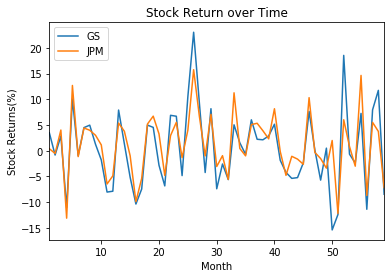

In [804]:
returns[company_one].plot()
returns[company_two].plot()
plt.ylabel('Stock Returns(%)')
plt.title('Stock Return over Time')
plt.xlabel('Month')
plt.legend()
plt.show()

The above plot is just a visual representation of how closely Goldman Sachs and JP Morgan stocks follow each other in their monthly returns.